<a href="https://colab.research.google.com/github/AlbertFlorinus/mnistcnn/blob/master/notebook/visualer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/AlbertFlorinus/mnistcnn

Cloning into 'mnistcnn'...
remote: Enumerating objects: 1399, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1399 (delta 122), reused 110 (delta 68), pack-reused 1200
Receiving objects: 100% (1399/1399), 40.92 MiB | 34.80 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [ ]:
import sys
import os
import matplotlib.pyplot as plt
from cv2 import cv2
import keras
import numpy as np
from keras.preprocessing import image
import math
from scipy import ndimage

In [ ]:
py_file_location = "/content/mnistcnn/scripts"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
from show_preds import preprocessor, into_alnet

In [ ]:
model = keras.models.load_model("/content/mnistcnn/ALnet-3.0.h5")

In [ ]:
def weighted_class(prediction_list, prediction2_list):

  # x1 and x2 are indexes for elements (what digit is guessed) of highest value for images gray and gray2
  x1 = np.argmax(prediction_list)
  x2 = np.argmax(prediction2_list)

  # c is the highest value in prediction_list
  # v is the highest value in prediction2_list
  c = prediction_list[0][x1]
  v = prediction2_list[0][x2]

  # b is the value of prediction_list at index of prediction2_list highest value
  # n is the value of prediction2_list at index of predition_list highest value
  b = prediction_list[0][x2]
  n = prediction2_list[0][x1]

  # this helps us decide what prediction is most likely to be correct, by comparing the values below.
  k = (c+b)/2
  j = (v+n)/2
  if k > j:
      classname = x1

  if j > k:
      classname = x2
  
  return classname

In [ ]:
def show_result(test_img, test_img2, classname, filename):
  # reshaping again for showing image to user
  test_img = test_img.reshape((112,112))
  test_img2 = test_img2.reshape((112,112))

  # lines 181-195 displays to the user gray and gray2, values of k and j, and the estimated classname for the original image chosen
  fig = plt.figure(figsize=(8,8))
  columns = 3
  rows = 1
  plt.gray()
  #fig.add_subplot(rows, columns, 1).set_title("adaptive_Threshold\n k = {}".format(k))
  fig.add_subplot(rows, columns, 1).set_title("adaptive_Threshold")
  plt.imshow(test_img)
  #fig.add_subplot(rows, columns, 2).set_title("Threshold\n j = {}".format(j))
  fig.add_subplot(rows, columns, 2).set_title("Threshold")
  plt.imshow(test_img2)
  

  fig.add_subplot(rows, columns, 3).set_title("Orig img")

  orig = cv2.imread(f"/content/mnistcnn/digits/{filename}", 0)
  plt.imshow(orig)
  fig.suptitle(f"Image shows a {classname}")
  

  plt.show()


In [ ]:
def getBestShift(img):
  # preprocessing

  # calculate the center of mass of the image along y and x axis
  cy,cx = ndimage.measurements.center_of_mass(img)
  
  rows,cols = img.shape
  shiftx = np.round(cols/2.0-cx).astype(int)
  shifty = np.round(rows/2.0-cy).astype(int)
  return shiftx,shifty

In [ ]:
def shift(img,sx,sy):
  # preprocessing
  rows,cols = img.shape
  M = np.float32([[1,0,sx],[0,1,sy]])
  shifted = cv2.warpAffine(img,M,(cols,rows))
  return shifted

In [ ]:
def image_manip(subj):

  # this method uses the methods "shift" and "getBestShift" to preprocess the image.

  # this code (50-62) removes the rows and columns at the edge of the image,
  # which are completely black as a result of previous thresholding.
  # this resize the image to 71% rounded up of the previous size,
  # so that a size of 112x112 now becomes 80x80, with the edges not containing information,
  # of the digits now removed.
  while np.sum(subj[0]) == 0:
    subj = subj[1:]

  while np.sum(subj[:,0]) == 0:
    subj = np.delete(subj,0,1)

  while np.sum(subj[-1]) == 0:
    subj = subj[:-1]

  while np.sum(subj[:,-1]) == 0:
    subj = np.delete(subj,-1,1)

  rows,cols = subj.shape

  # this resize the
  if rows > cols:
    factor = 80.0/rows
    rows = 80
    cols = int(round(cols*factor))
    subj = cv2.resize(subj, (cols,rows))
  else:
    factor = 80.0/cols
    cols = 80
    rows = int(round(rows*factor))
    subj = cv2.resize(subj, (cols, rows))

  # get padding
  colsPadding = (int(math.ceil((112-cols)/2.0)),int(math.floor((112-cols)/2.0)))
  rowsPadding = (int(math.ceil((112-rows)/2.0)),int(math.floor((112-rows)/2.0)))

  # apply padding
  subj = np.lib.pad(subj,(rowsPadding,colsPadding),'constant')

  # some preprocessing 
  shiftx,shifty = getBestShift(subj)
  shifted = shift(subj,shiftx,shifty)
  subj_done = shifted
  return subj_done

In [ ]:
def decide(filename):
  # reading image to grayscale
  gray = cv2.imread(f"/content/mnistcnn/digits/{filename}", 0)

  # dilate img
  dilated_gray = cv2.dilate(gray, np.ones((3,3), np.uint8))

  # median blur the dilated img to further suppress detail
  bg_gray = cv2.medianBlur(dilated_gray, 21)
  

  # calculate difference between gray(original img) and bg_gray.
  # identical pixels will be black(close to 0 difference), the digits details will be white(large difference).
  diff_gray = 255 - cv2.absdiff(gray, bg_gray)

  # normalize the image, so that we use the full dynamic range.
  #norm_gray = diff_gray.copy()
  norm_gray = diff_gray.copy()
  cv2.normalize(diff_gray, norm_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # now the image is still gray in some areas, so we truncate that away and re-normalize the image.
  #
  _, thr_gray = cv2.threshold(norm_gray, 253, 0, cv2.THRESH_TRUNC)
  cv2.normalize(thr_gray, thr_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # inverting color and rezising image to 112x112
  gray1 = cv2.resize(255-thr_gray, (112, 112), interpolation=cv2.INTER_AREA)

  # we have variables gray and gray2 to differentiate between two ways of thresholding.
  # Alnet-2.0 will make predictions on both of these, and combine the two to get our resulting classification.
  
  gray = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 3)
  #gray = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 3)
  (thresh, gray2) = cv2.threshold(gray1, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  # converting PIL image to numpy array
  img = image.img_to_array(gray)
  img2 = image.img_to_array(gray2)

  # reshaping to 1 channel (its only 1 image), 112x112 shape, and 1 color channel (grayscale)
  test_img = img.reshape((1,112,112,1))
  test_img2 = img2.reshape((1,112,112,1))

  # change datatype from uint8 to float32
  test_img = img.astype('float32')
  test_img2 = img2.astype('float32')


  # normalizing pixels in the decimal range 0 to 1
  test_img /= 255
  test_img2 /= 255


  # extend axis at index[0] to ready for prediction
  test_img = np.expand_dims(test_img, axis=0)
  test_img2 = np.expand_dims(test_img2, axis=0)

  # get network output (10 nodes)
  # prediction_list is prediction of gray
  # prediction2_list is prediction of gray2
  prediction_list = model.predict(test_img)
  prediction2_list = model.predict(test_img2)
  
  return prediction_list, prediction2_list, test_img, test_img2


In [ ]:
def decide2(filename):
  # reading image to grayscale
  gray = cv2.imread(f"/content/mnistcnn/digits/{filename}", 0)

  # dilate img
  dilated_gray = cv2.dilate(gray, np.ones((7,7), np.uint8))

  # median blur the dilated img to further suppress detail
  bg_gray = cv2.medianBlur(dilated_gray, 21)

  # calculate difference between gray(original img) and bg_gray.
  # identical pixels will be black(close to 0 difference), the digits details will be white(large difference).
  diff_gray = 255 - cv2.absdiff(gray, bg_gray)

  # normalize the image, so that we use the full dynamic range.
  norm_gray = diff_gray.copy()
  cv2.normalize(diff_gray, norm_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # now the image is still gray in some areas, so we truncate that away and re-normalize the image.
  _, thr_gray = cv2.threshold(norm_gray, 253, 0, cv2.THRESH_TRUNC)
  cv2.normalize(thr_gray, thr_gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

  # inverting color and rezising image to 112x112
  gray1 = cv2.resize(255-thr_gray, (112, 112), interpolation=cv2.INTER_AREA)

  # we have variables gray and gray2 to differentiate between two ways of thresholding.
  # Alnet-2.0 will make predictions on both of these, and combine the two to get our resulting classification.
  gray = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 3)
  (thresh, gray2) = cv2.threshold(gray1, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  # converting PIL image to numpy array

  img = image.img_to_array(gray)
  img2 = image.img_to_array(gray2)

  # reshaping to 1 channel (its only 1 image), 112x112 shape, and 1 color channel (grayscale)
  test_img = img.reshape((1,112,112,1))
  test_img2 = img2.reshape((1,112,112,1))

  # change datatype from uint8 to float32
  test_img = img.astype('float32')
  test_img2 = img2.astype('float32')


  # normalizing pixels in the decimal range 0 to 1
  test_img /= 255
  test_img2 /= 255


  # extend axis at index[0] to ready for prediction
  test_img = np.expand_dims(test_img, axis=0)
  test_img2 = np.expand_dims(test_img2, axis=0)

  # get network output (10 nodes)
  # prediction_list is prediction of gray
  # prediction2_list is prediction of gray2
  prediction_list = model.predict(test_img)
  prediction2_list = model.predict(test_img2)
  
  return prediction_list, prediction2_list, test_img, test_img2

image_manip...


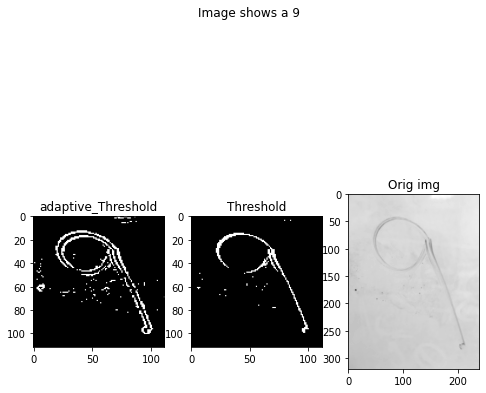

...


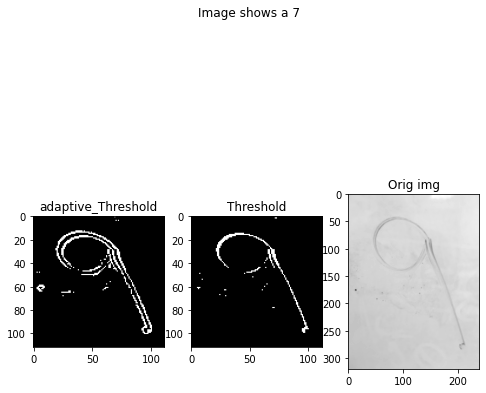

image_manip...


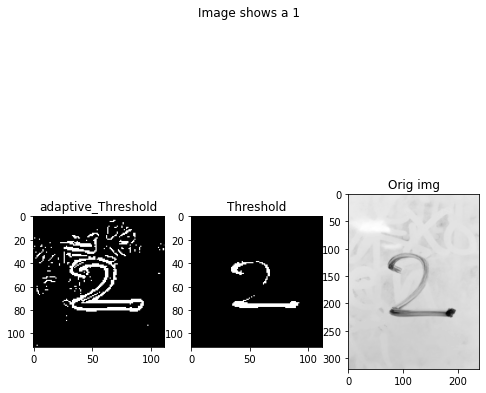

...


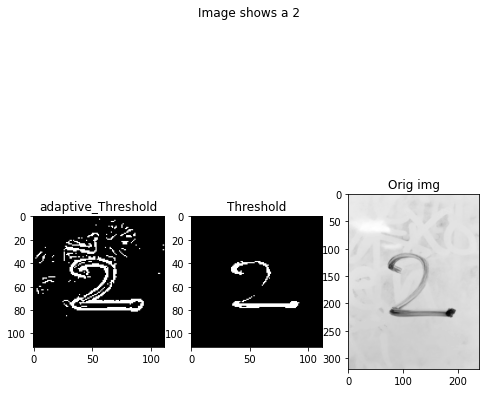

image_manip...


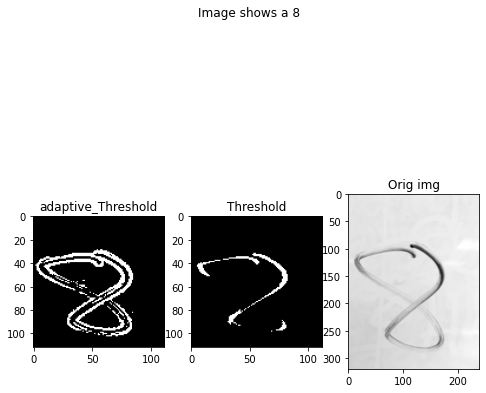

...


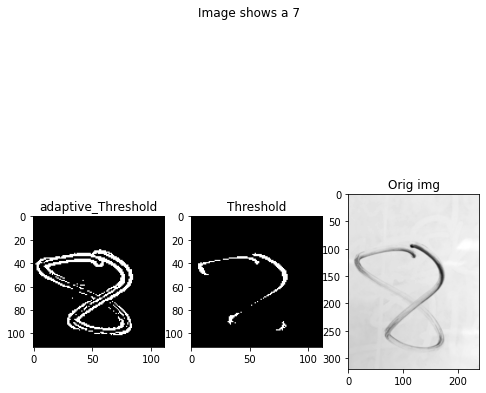

image_manip...


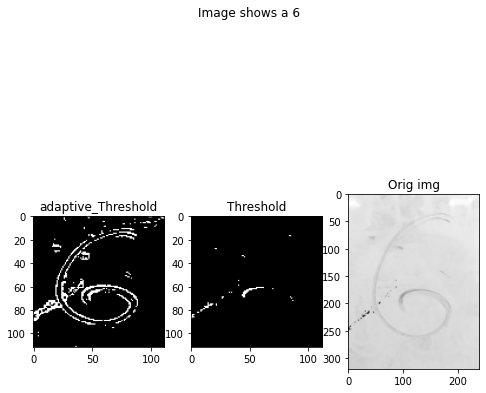

...


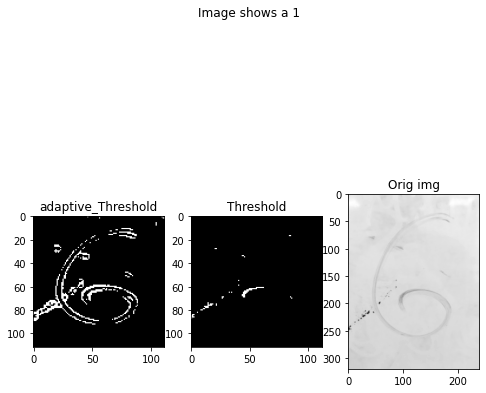

In [ ]:
count = 0
for filename in os.listdir("/content/mnistcnn/digits"):

    if filename.endswith((".DS_Store")):
        pass
    elif count < 1:
        count += 1
    elif count < len(os.listdir("/content/mnistcnn/digits")):
    #elif count < 10:
        pred1, pred2, im1, im2 = decide2(filename)
        classname2 = weighted_class(pred1, pred2)
        #show_result(im1, im2, classname2, filename)
        
        prediction_list, prediction2_list, img1, img2 = decide(filename)
        classname = weighted_class(prediction_list, prediction2_list)
        if classname2 != classname:
          print("image_manip...")
          show_result(im1, im2, classname2, filename)
          print("...")
          show_result(img1, img2, classname, filename)
        count += 1